# Production version of python rad transfer code

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
from glob import glob
from scipy.interpolate import interp1d
from scipy.ndimage.filters import gaussian_filter1d
from hapi import *
import pandas as pd

from matplotlib.font_manager import FontProperties
from scipy.interpolate import CubicSpline

%run simulate_radiances_utils.py
%run locations.py


font = {'weight' : 'bold',
        'size'   : 12}
label_fontdict = {'weight' : 'bold',
        'size'   : 12}
title_fontdict = {'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

HAPI version: 1.1.0.9.7
To get the most up-to-date version please check http://hitran.org/hapi
ATTENTION: Python versions of partition sums from TIPS-2017 are now available in HAPI code

           It is free to use HAPI. If you use HAPI in your research or software development,
           please cite it using the following reference:
           R.V. Kochanov, I.E. Gordon, L.S. Rothman, P. Wcislo, C. Hill, J.S. Wilzewski,
           HITRAN Application Programming Interface (HAPI): A comprehensive approach
           to working with spectroscopic data, J. Quant. Spectrosc. Radiat. Transfer 177, 15-30 (2016)
           DOI: 10.1016/j.jqsrt.2016.03.005


In [4]:
reanlaysis_vars_subset = ['PS','PL','QV','T', 'DELP']

In [5]:
loc_label = 'summit'


In [6]:
save_figs_rel_dir = '/home/cchristo/proj_christian/rad_transfer_python/figs/'

In [7]:
input_cs_matrix_rel_path = '/export/data2/groupMembers/cchristo/cs_matrices/' + loc_label + '/'
reanalysis_dir = '/export/data2/groupMembers/cchristo/reanalysis_3d/merra2/2015/'
file_type = '*.nc'

all_file_paths_cs_matrix = [y for x in os.walk(input_cs_matrix_rel_path) for y in glob(os.path.join(x[0], file_type))]
all_file_paths_reanalysis = [y for x in os.walk(reanalysis_dir) for y in glob(os.path.join(x[0], '*.nc4'))]

# Open reanlysis data

In [129]:


ds_3d = xr.open_mfdataset(all_file_paths_reanalysis, 
                          combine='by_coords')[reanlaysis_vars_subset]

In [260]:
# ds_3d.isel(time = 56)
# ds_3d_seasonal = ds_3d.groupby('time.season').mean()

In [262]:
# ds_3d

In [8]:
loc_lat =  loc_lat_lon_map[loc_label][0] #72.5796
loc_lon = loc_lat_lon_map[loc_label][1] #-38.4588
time_ii = 63

ds_single = ds_3d.sel(lat = loc_lat, lon = loc_lon, method = 'nearest')
# select single time
# ds_single = ds_single.isel(time = time_ii)
# time_i = ds_single.time

# seasonal mea 
ds_seasonal = ds_single.groupby('time.season').mean('time')

# ds_single.load()
# p_prof, T_prof, dz_prof,  vmr_h2o_prof, VCD_dry_prof, rho_N_h2o_prof, rho_N_prof = compute_profile_properties_merra2(ds_single, verbose=False)

# print(time_i)

In [131]:
%%time
ds_seasonal.load()
# ds_single

CPU times: user 55 µs, sys: 18 µs, total: 73 µs
Wall time: 81.1 µs


<xarray.Dataset>
Dimensions:  (lev: 72, season: 4)
Coordinates:
    lon      float64 -38.75
    lat      float64 72.5
  * lev      (lev) float64 1.0 2.0 3.0 4.0 5.0 6.0 ... 68.0 69.0 70.0 71.0 72.0
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    PS       (season) float32 65277.723 69593.3 65056.312 67875.625
    PL       (season, lev) float32 1.5000001 2.635001 ... 66455.125 67367.52
    QV       (season, lev) float32 1.2024224e-06 1.786119e-06 ... 0.0014142165
    T        (season, lev) float32 202.94925 207.71889 ... 259.07742 256.78262
    DELP     (season, lev) float32 1.0000001 1.2700003 ... 807.8746 1016.5832

In [182]:
for seas_i in ds_seasonal.season:
#     print
    print(seas_i)

<xarray.DataArray 'season' ()>
array('DJF', dtype='<U3')
Coordinates:
    lon      float64 -38.75
    lat      float64 72.5
    season   <U3 'DJF'
<xarray.DataArray 'season' ()>
array('JJA', dtype='<U3')
Coordinates:
    lon      float64 -38.75
    lat      float64 72.5
    season   <U3 'JJA'
<xarray.DataArray 'season' ()>
array('MAM', dtype='<U3')
Coordinates:
    lon      float64 -38.75
    lat      float64 72.5
    season   <U3 'MAM'
<xarray.DataArray 'season' ()>
array('SON', dtype='<U3')
Coordinates:
    lon      float64 -38.75
    lat      float64 72.5
    season   <U3 'SON'


In [134]:
season_i = 0
p_prof, T_prof, dz_prof,  vmr_h2o_prof, VCD_dry_prof, rho_N_h2o_prof, rho_N_prof = compute_profile_properties_merra2(ds_seasonal.isel(season = season_i), verbose=False)



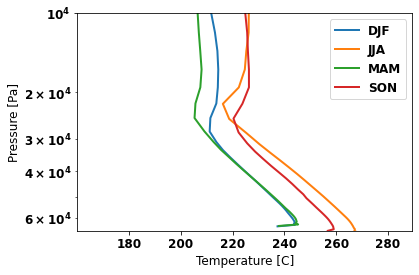

In [188]:
for seas_i in ds_seasonal.season:
    plot_ds = ds_seasonal.sel(season = seas_i)
    p_prof, T_prof = plot_ds['PL'].values, plot_ds['T'].values
    plot_profile(p_prof, T_prof, min_pres=1e4, label=seas_i.values,
                 newfig_bool = False)
    plt.legend()

In [162]:
def interpolate_profile(p_prof, 
                        var_prof, 
                        p_interp_grid, 
                        method = 'CubicSpline',
                        return_interp_obj = False):
    '''
    Interpolate profile to given pressure grid. 
    
    Args
    -----
    p_prof - np.array
        pressure profile 
    var_prof - np.array
        profile of variable to interpolate
    method - str {'CubicSpline',}
        interpolation method to use
        
    return_interp_obj - bool
        if True, return scipy.interpolate object along with profile
        
        
    Returns
    -------
    (p_interp_grid, var_prof_interpolated) - Profile interpolated to p_interp_grid
    
    '''
    
    if method == 'CubicSpline':
        spline_obj = CubicSpline(p_prof,T_prof)
        var_prof_interpolated = spline_obj(p_interp_grid)
        
    if return_interp_obj:
        return (p_interp_grid, var_prof_interpolated, spline_obj)
    else:
        return (p_interp_grid, var_prof_interpolated)

In [108]:
p_interp_grid = np.linspace(1e3, p_prof.max(), 300)
# p_interp_grid = np.logspace(1e3, p_prof.max(), 200)
res = interpolate_profile(p_prof, T_prof, p_interp_grid)

In [110]:
# res[1]
# plt.plot(p_interp_grid , '.')
# p_interp_grid

In [112]:
# p_interp_grid
# plot_profile(*res , min_pres = 6e3)

# Open saved cross sections

In [117]:
input_cs_matrix_path_format = input_cs_matrix_rel_path + '{year}/{month:02d}/cs_matrix_{year}{month:02d}{day:02d}_{hour:02d}{minute:02d}.nc'
input_cs_matrix_path = input_cs_matrix_path_format.format(year = time_i['time.year'].item(), 
                                                             month = time_i['time.month'].item(), 
                                                             day = time_i['time.day'].item(),
                                                             hour = time_i['time.hour'].item(), 
                                                             minute = time_i['time.minute'].item())
cs_matrix_ds = xr.open_dataset(input_cs_matrix_path)

# cs_matrix_ds = xr.open_mfdataset(all_file_paths_cs_matrix, combine = 'by_coords')
# cs_matrix_ds = cs_matrix_ds.sel(time = time_i)



NameError: name 'time_i' is not defined

# Create new cross section matrix

In [136]:
%%capture
xmin = 400
# Maximum wavenumber
xmax = 2100
# Actually downloading the data 
# (we have to know the HITRAN molecule numbers, given in http://hitran.org/docs/molec-meta/)
fetch('H2O_S',1,1,xmin,xmax)
fetch('CO2_S',2,1,xmin,xmax)
fetch('CH4_S',6,1,xmin,xmax)

# Let us hust get line position nu and line strength sw for the different molecules:
nu_H2O,sw_H2O = getColumns('H2O_S',['nu','sw'])
nu_CH4,sw_CH4 = getColumns('CH4_S',['nu','sw'])
nu_CO2,sw_CO2 = getColumns('CO2_S',['nu','sw'])


In [142]:
##
cs_matrix_ds = create_cross_section_matrix_hapi(p_prof, T_prof, 
                                     xmin, xmax, 
                                     time_i = ds_seasonal.isel(season = season_i)['season'],
                                     output_path=None)

In [411]:
# cs_matrix_ds
ds_3d

<xarray.Dataset>
Dimensions:  (lat: 361, lev: 72, lon: 576, time: 224)
Coordinates:
  * time     (time) datetime64[ns] 2015-01-01T01:30:00 ... 2015-09-07T22:30:00
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lev      (lev) float64 1.0 2.0 3.0 4.0 5.0 6.0 ... 68.0 69.0 70.0 71.0 72.0
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
Data variables:
    PS       (time, lat, lon) float32 dask.array<chunksize=(8, 361, 576), meta=np.ndarray>
    PL       (time, lev, lat, lon) float32 dask.array<chunksize=(8, 72, 361, 576), meta=np.ndarray>
    QV       (time, lev, lat, lon) float32 dask.array<chunksize=(8, 72, 361, 576), meta=np.ndarray>
    T        (time, lev, lat, lon) float32 dask.array<chunksize=(8, 72, 361, 576), meta=np.ndarray>
    DELP     (time, lev, lat, lon) float32 dask.array<chunksize=(8, 72, 361, 576), meta=np.ndarray>
Attributes:
    History:                           Original file generated: Thu Mar 12 05...
    Comment:                           GMAO filename: d5124_m2_jan10.tavg3_3d...
    Filename:                          MERRA2_400.tavg3_3d_asm_Nv.20150101.nc4
    Conventions:                       CF-1
    Institution:                       NASA Global Modeling and Assimilation ...
    References:                        http://gmao.gsfc.nasa.gov
    Format:                            NetCDF-4/HDF-5
    SpatialCoverage:                   global
    VersionID:                         5.12.4
    TemporalRange:                     1980-01-01 -> 2016-12-31
    identifier_product_doi_authority:  http://dx.doi.org/
    ShortName:                         M2T3NVASM
    GranuleID:                         MERRA2_400.tavg3_3d_asm_Nv.20150101.nc4
    ProductionDateTime:                Original file generated: Thu Mar 12 05...
    LongName:                          MERRA2 tavg3_3d_asm_Nv: 3d,3-Hourly,Ti...
    Title:                             MERRA2 tavg3_3d_asm_Nv: 3d,3-Hourly,Ti...
    SouthernmostLatitude:              -90.0
    NorthernmostLatitude:              90.0
    WesternmostLongitude:              -180.0
    EasternmostLongitude:              179.375
    LatitudeResolution:                0.5
    LongitudeResolution:               0.625
    DataResolution:                    0.5 x 0.625 (72 native layers)
    Source:                            CVS tag: GEOSadas-5_12_4
    Contact:                           http://gmao.gsfc.nasa.gov
    identifier_product_doi:            10.5067/SUOQESM06LPK
    RangeBeginningDate:                2015-01-01
    RangeBeginningTime:                00:00:00.000000
    RangeEndingDate:                   2015-01-01
    RangeEndingTime:                   23:59:59.000000

In [314]:

cs_matrix_co2 = cs_matrix_ds['cs_matrix_co2'].values
cs_matrix_ch4 = cs_matrix_ds['cs_matrix_ch4'].values
cs_matrix_h2o = cs_matrix_ds['cs_matrix_h2o'].values

nu_ = cs_matrix_ds['nu'].values
NLEV = len(cs_matrix_ds['pressure'])

In [205]:
# cs_matrix_co2.shape
# np.diff(nu_)

array([0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01])

# Compute pdf of downwelling radiation for each time 

In [144]:
Rdown, T = compute_downwelling_radiation(cs_matrix_co2, 
                                         cs_matrix_h2o, 
                                         cs_matrix_ch4, 
                                         T_prof,
                                         VCD_dry_prof, 
                                         vmr_h2o_prof,
                                         nu_)

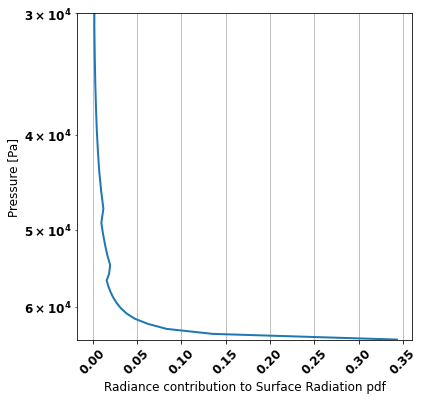

In [145]:
Rdown_pdf =  Rdown.sum(axis =0)
Rdown_pdf = Rdown_pdf/Rdown_pdf.sum()
plot_profile(p_prof, Rdown_pdf, min_pres = 3e4, 
             xlabel = 'Radiance contribution to Surface Radiation pdf',
             rotation = 45)

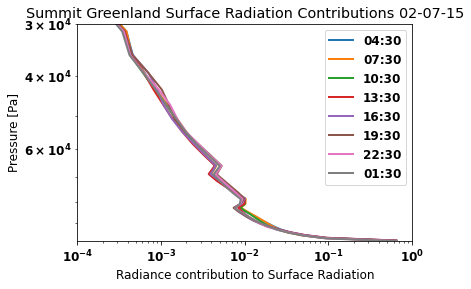

In [113]:
# for time_ii in range(8):
for time_ii in range(57, 57 + 8):
    ds_single = ds_3d.sel(lat = loc_lat, lon = loc_lon, method = 'nearest')
    ds_single = ds_single.isel(time = time_ii)
    time_i = ds_single.time
    ds_single.load()
    p_prof, T_prof, dz_prof,  vmr_h2o_prof, VCD_dry_prof, rho_N_h2o_prof, rho_N_prof = compute_profile_properties_merra2(ds_single, verbose=False)
    ts = pd.to_datetime(str(time_i.values)) 
    d = ts.strftime('%H:%M')
    #######
    input_cs_matrix_path = input_cs_matrix_path_format.format(year = time_i['time.year'].item(), 
                                                             month = time_i['time.month'].item(), 
                                                             day = time_i['time.day'].item(),
                                                             hour = time_i['time.hour'].item(), 
                                                             minute = time_i['time.minute'].item())
    cs_matrix_ds = xr.open_dataset(input_cs_matrix_path)
    
    cs_matrix_co2 = cs_matrix_ds['cs_matrix_co2'].values
    cs_matrix_ch4 = cs_matrix_ds['cs_matrix_ch4'].values
    cs_matrix_h2o = cs_matrix_ds['cs_matrix_h2o'].values

    nu_ = cs_matrix_ds['nu']
    NLEV = len(cs_matrix_ds['pressure'])
    #########
    Rdown, T = compute_downwelling_radiation(cs_matrix_co2, 
                                         cs_matrix_h2o, 
                                         cs_matrix_ch4, 
                                         T_prof,
                                         VCD_dry_prof, 
                                         vmr_h2o_prof,
                                         nu_)
    
    Rdown_pdf =  Rdown.sum(axis =0)
    Rdown_pdf = Rdown_pdf/Rdown_pdf.sum()
    ax = plot_profile(p_prof, Rdown_pdf, 
                 newfig_bool = False, 
                 min_pres = 3e4, 
                 xlim = [1e-4, 1],
                 xlabel = 'Radiance contribution to Surface Radiation',
                 label = d)
    ax.set_xscale('log')
    ax.set_title('Summit Greenland Surface Radiation Contributions ' + ts.strftime('%d-%m-%y'))
plt.legend()
# plt.savefig(save_figs_rel_dir + 'surface_rad_contribution/' + 'summit_7_01.png', dpi = 300)

<Figure size 432x288 with 0 Axes>

In [60]:
save_figs_rel_dir

'/home/cchristo/proj_christian/rad_transfer_python/figs/'

(240.0, 270.0)

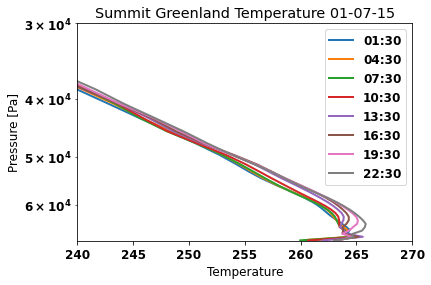

In [175]:
# for time_ii in range(8):
for time_ii in range(56, 56 + 8):
    ds_single = ds_3d.sel(lat = loc_lat, lon = loc_lon, method = 'nearest')
    ds_single = ds_single.isel(time = time_ii)
    time_i = ds_single.time
    ds_single.load()
    p_prof, T_prof, dz_prof,  vmr_h2o_prof, VCD_dry_prof, rho_N_h2o_prof, rho_N_prof = compute_profile_properties_merra2(ds_single, verbose=False)
    ts = pd.to_datetime(str(time_i.values)) 
    d = ts.strftime('%H:%M')
    ax = plot_profile(p_prof,  T_prof, # rho_N_h2o_prof,
                 newfig_bool = False, 
                 min_pres = 3e4, 
#                  min_pres = 5.5e4,
                 xlabel = 'Temperature',
                 label = d)
#     ax.set_title('Summit Greenland H2O Mixing Ratio ' + ts.strftime('%d-%m-%y'))
    ax.set_title('Summit Greenland Temperature ' + ts.strftime('%d-%m-%y'))
plt.legend()
plt.ylabel('Pressure [Pa]')
plt.xlim([240, 270])
# plt.savefig(save_figs_rel_dir + 'profiles/' + 'summit_temp_7_15.png', dpi = 300)
# plt.savefig(save_figs_rel_dir + 'profiles/' + 'summit_h2o_mixing_7_15.png', dpi = 300)

# Look at single profile

In [387]:
AMF = 1
# Compute transmission for each layer:
T = np.zeros((len(nu_),NLEV))
# Generate matrices of optical thickness per layer now for each gas: 
tau_co2 = cs_matrix_co2*VCD_dry_prof*400.e-6*AMF 
tau_co2_pre = cs_matrix_co2*VCD_dry_prof*270.e-6*AMF
#VCD_h2o = dz*rho_N_h2o
tau_h2o = cs_matrix_h2o*VCD_dry_prof*vmr_h2o_prof*AMF 
tau_ch4 = cs_matrix_ch4*VCD_dry_prof*1.8e-6*AMF 

## Compute Transmissions For Each Layer

In [388]:
T = np.exp(-tau_co2)*np.exp(-tau_h2o)*np.exp(-tau_ch4)
T_pre = np.exp(-tau_co2_pre)*np.exp(-tau_h2o)*np.exp(-tau_ch4)
TdCO2 = np.exp(-2*tau_co2)*np.exp(-tau_h2o)*np.exp(-tau_ch4)
TdH2O = np.exp(-tau_co2)*np.exp(-2*tau_h2o)*np.exp(-tau_ch4)
TdCH4 = np.exp(-tau_co2)*np.exp(-tau_h2o)*np.exp(-2*tau_ch4)

In [215]:
T.shape

(200000, 72)

## Generate Planck curve per layer

In [394]:
# Generate Planck curve per layer + surface:
wl_nu = 1.e7/nu_*1.e-9
wavenum_m = nu_*1e2
# Use skin temperature of 300K
# B_surf = planck(wl_nu,300)
B = np.zeros((len(nu_),NLEV))
for i in range(NLEV):
#     B[:,i] = planck(wl_nu,T_prof[i])
    B[:,i] = planck_wavenumber(wavenum_m,T_prof[i])*1e2

In [382]:
# wl_nu[0].item()
B.shape

(170000, 72)

# Calculate Downwelling Radiation

In [395]:
Rdown = np.zeros((len(nu_),NLEV))
Rdown_pre = np.zeros((len(nu_),NLEV))
# Rdown_dCO2 = np.zeros((len(nu_),NLEV))
# Rdown_dCH4 = np.zeros((len(nu_),NLEV))
# Rdown_dH2O = np.zeros((len(nu_),NLEV))

for i in range(NLEV):
    Rdown[:,i] = B[:,i]*(1-T[:,i])*np.prod(T[:,i+1:],axis=1)
    Rdown_pre[:,i] = B[:,i]*(1-T_pre[:,i])*np.prod(T_pre[:,i+1:],axis=1)
#     Rdown_dCO2[:,i] = B[:,i]*(1-TdCO2[:,i])*np.prod(TdCO2[:,i+1:],axis=1)
#     Rdown_dCH4[:,i] = B[:,i]*(1-TdCH4[:,i])*np.prod(TdCH4[:,i+1:],axis=1)
#     Rdown_dH2O[:,i] = B[:,i]*(1-TdH2O[:,i])*np.prod(TdH2O[:,i+1:],axis=1)

In [396]:
Surface_Down = np.sum(Rdown,axis=1)
Surface_Down_pre = np.sum(Rdown_pre,axis=1)
# Surface_Down_dH2O = np.sum(Rdown_dH2O,axis=1)

In [385]:
# np.diff(nu_)
# nu_.min()
# nu_
%run simulate_radiances_utils.py

In [371]:
rad_array = planck_wavenumber(nu_*1e2,260)
# drad_dcmk = np.diff(rad_array, prepend = rad_array[0])
# rad_per_bin = np.multiply(drad_dcmk, 1e-4*nu_.values)
rad_array

array([9.35561168e-04, 9.35573209e-04, 9.35585248e-04, ...,
       9.90271553e-06, 9.90230901e-06, 9.90190250e-06])

In [407]:
# plt.plot(nu_, rad_array*1e2)
# plt.grid()


In [399]:
# W_mum_mW_cm = 10000/1000
W_m_mW_cm = 1e2*1e3
# W_mum_mW_cm = 1e-3

test


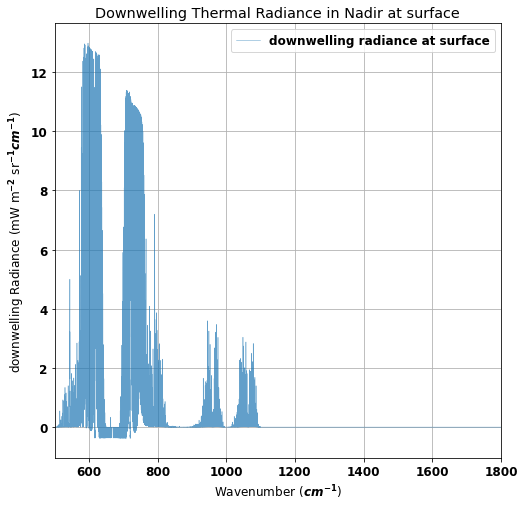

In [412]:
print('test')

plt.figure(figsize = (8,8))
plt.plot(nu_,1e3*(Surface_Down - Surface_Down_pre),label='downwelling radiance at surface', alpha=0.7 ,linewidth = 0.5)
# plt.plot(wl_nu*1e6,Surface_Down_dH2O,label='downwelling radiance at surface (double H$_2$O', alpha=0.7)#, wl_nu*1e6, np.sum(R,axis=1), wl_nu*1e6,R_surf)

plt.legend(loc=0)
# plt.xlabel('Wavelength ($\mu$m)')
plt.xlabel('Wavenumber ($cm^{-1}$)')
# plt.ylabel('downwelling Radiance (W m$^{-2}$ sr$^{-1}$ $\mu$m$^{-1}$)')
plt.ylabel(r'downwelling Radiance (mW m$^{-2}$ sr$^{-1} cm^{-1}$)')
plt.xlim((500,1800))
plt.title('Downwelling Thermal Radiance in Nadir at surface')
plt.grid()

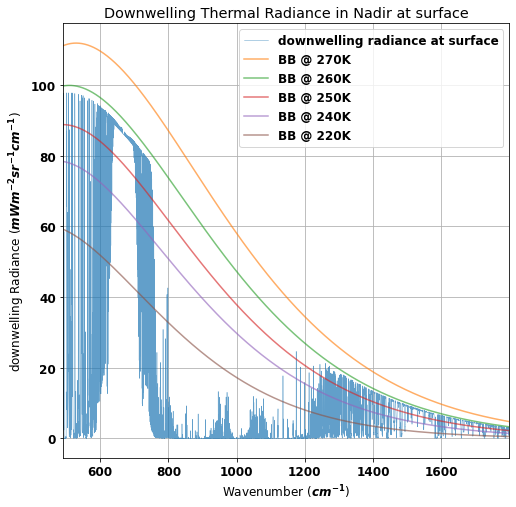

In [402]:
plt.figure(figsize = (8,8))
plt.plot(nu_, 1e3*Surface_Down,label='downwelling radiance at surface', alpha=0.7 ,linewidth = 0.5)
# plt.plot(wl_nu*1e6,Surface_Down_dH2O,label='downwelling radiance at surface (double H$_2$O', alpha=0.7)#, wl_nu*1e6, np.sum(R,axis=1), wl_nu*1e6,R_surf)

plt.plot(nu_, W_m_mW_cm*planck_wavenumber(wavenum_m,270),label='BB @ 270K',alpha=0.63)
plt.plot(nu_, W_m_mW_cm*planck_wavenumber(wavenum_m,260),label='BB @ 260K',alpha=0.63)
plt.plot(nu_, W_m_mW_cm*planck_wavenumber(wavenum_m,250),label='BB @ 250K',alpha=0.63)
plt.plot(nu_, W_m_mW_cm*planck_wavenumber(wavenum_m,240),label='BB @ 240K',alpha=0.63)
plt.plot(nu_, W_m_mW_cm*planck_wavenumber(wavenum_m,220),label='BB @ 220K',alpha=0.63)
plt.legend(loc=0)

plt.xlim((491,1799))
# plt.xlabel('Wavelength ($\mu$m)')
plt.xlabel('Wavenumber ($cm^{-1}$)')
# plt.ylabel('downwelling Radiance (W m$^{-2}$ sr$^{-1}$ $\mu$m$^{-1}$)')
plt.ylabel(r'downwelling Radiance ($mW m^{-2} sr^{-1} cm^{-1}$)')
# plt.xlim((4,30))
plt.title('Downwelling Thermal Radiance in Nadir at surface')
plt.grid()
# plt.savefig(save_figs_rel_dir + 'black_body_curves/' + 'summit_greenland_7_1_22_30.png', dpi = 300)

Text(0.5, 1.0, 'Downwelling Thermal Radiance in Nadir at surface')

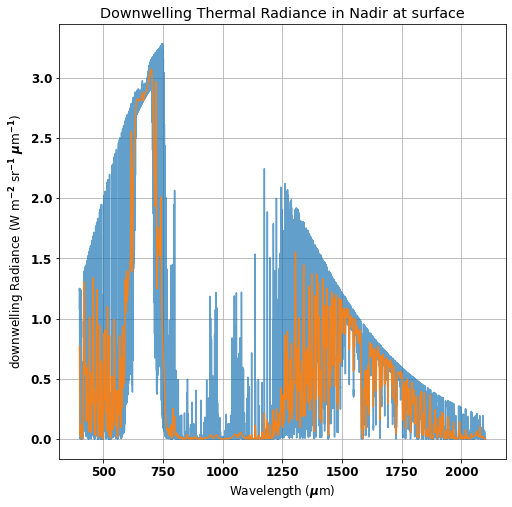

In [157]:
plt.figure(figsize = (8,8))
plt.plot(nu_,Surface_Down,label='downwelling radiance at surface', alpha=0.7)
plt.plot(nu_,gaussian_filter1d(Surface_Down,100),label='downwelling radiance at surface', alpha=0.9)
# plt.plot(wl_nu*1e6,gaussian_filter1d(Surface_Down_dH2O,200),label='downwelling radiance at surface', alpha=0.9)
plt.grid()
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('downwelling Radiance (W m$^{-2}$ sr$^{-1}$ $\mu$m$^{-1}$)')
# plt.xlim((4,30))
plt.title('Downwelling Thermal Radiance in Nadir at surface')

In [28]:
# plt.plot(T_local)
# plot_profile(p_prof, q_local, newfig_bool = False, xlabel= 'Specific Humidity')
# plt.ylim([p_full.max(), 10000])

(64665.54, 10000)

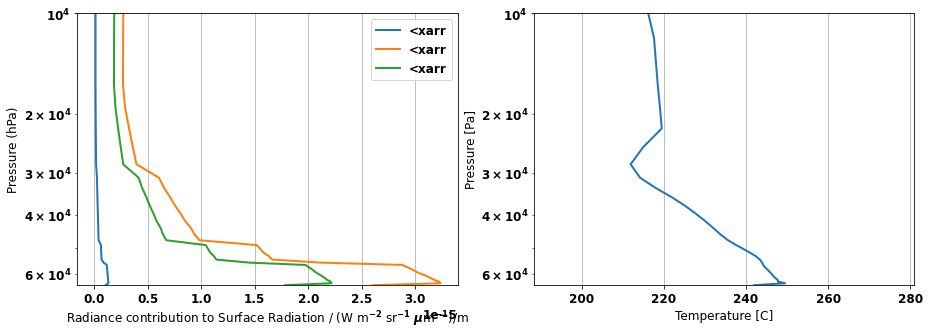

In [19]:
# fig, ax = plt.subplots(1,2)
i1, i2, i3 = 40000, 70000, 150000
plt.figure(figsize = (15,5))
plt.subplot(121)
plot_profile(p_prof, np.mean(Rdown[i1,:],axis=0)/dz_prof, newfig_bool = False, label = str(wl_nu[i1]*1e6)[:5])
plot_profile(p_prof, np.mean(Rdown[i2,:],axis=0)/dz_prof, newfig_bool = False, label = str(wl_nu[i2]*1e6)[:5])
rr = plot_profile(p_prof, np.mean(Rdown[i3,:],axis=0)/dz_prof, newfig_bool = False, label = str(wl_nu[i3]*1e6)[:5])

plt.xlabel('Radiance contribution to Surface Radiation / (W m$^{-2}$ sr$^{-1}$ $\mu$m$^{-1}$)/m')
plt.ylabel('Pressure (hPa)')
plt.ylim([p_prof.max(), 10000])
plt.legend()


plt.subplot(122)
plot_profile(p_prof, T_prof, newfig_bool = False)
# plot_profile(p_full, q_local, newfig_bool = False)
plt.ylim([p_prof.max(), 10000])

## Make pdf of downwelling radiation

In [24]:
Rdown.shape

(200000, 72)

In [34]:
Rdown.sum(axis =0)

array([1.20665070e-02, 2.70489618e-02, 5.31061230e-02, 1.60860774e-01,
       3.05833620e-01, 4.39481365e-01, 7.78232800e-01, 1.16315220e+00,
       1.19674043e+00, 1.27475974e+00, 1.43896374e+00, 1.45627500e+00,
       1.65122307e+00, 1.50137980e+00, 1.36667503e+00, 1.34794567e+00,
       1.16367211e+00, 8.30919145e-01, 5.55616338e-01, 5.98243796e-01,
       5.93133054e-01, 5.13797116e-01, 4.19787019e-01, 3.33931790e-01,
       3.94060235e-01, 4.71466390e-01, 5.50283188e-01, 7.36928107e-01,
       1.11216418e+00, 1.68142004e+00, 2.44015519e+00, 3.50742638e+00,
       5.21097788e+00, 7.60584133e+00, 1.14677301e+01, 1.79056926e+01,
       2.62106213e+01, 3.79919248e+01, 5.48676837e+01, 7.61970799e+01,
       1.06450017e+02, 1.38490393e+02, 1.67609382e+02, 1.64360880e+02,
       1.74375472e+02, 1.55418521e+02, 2.04232323e+02, 2.68858935e+02,
       3.49744273e+02, 4.40882102e+02, 5.57153927e+02, 6.83673728e+02,
       8.52829998e+02, 1.07411245e+03, 9.19105089e+02, 1.12990523e+03,
      

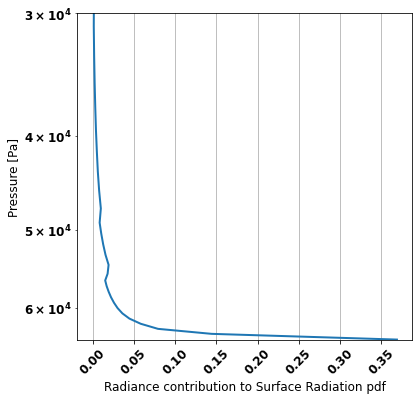

In [62]:
# plt.plot(Rdown[100000,:])
Rdown_pdf =  Rdown.sum(axis =0)
Rdown_pdf = Rdown_pdf/Rdown_pdf.sum()
plot_profile(p_prof, Rdown_pdf, min_pres = 3e4, 
             xlabel = 'Radiance contribution to Surface Radiation pdf',
             rotation = 45)

In [61]:
# plt.plot(Rdown[10,:][::-1]/dz_prof[::-1], np.cumsum(tau_co2[10,:][::-1]),label='AMSU-4')

# plt.legend(loc=0)
# # plt.ylim((10,0))
# plt.xlabel('Radiance contribution to TOA / (W m$^{-2}$ sr$^{-1}$ $\mu$m$^{-1}$)/m')
# plt.ylabel(r'$\tau$')

In [163]:
z_prof = np.cumsum(dz_prof[::-1])
interp_prof = interpolate_profile(p_prof, 
                    T_prof,
                    p_interp_grid = np.linspace(1e3, p_prof.max(), 300),
                    return_interp_obj=True)

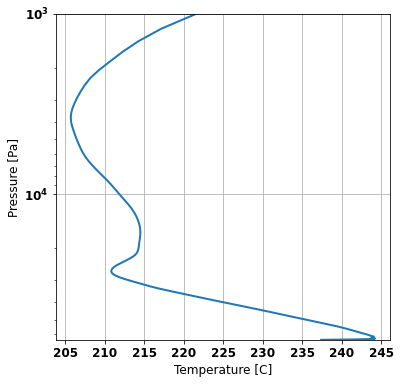

In [196]:
plot_profile(interp_prof[0], interp_prof[1], min_pres = 1e3)

In [199]:
interp_prof[-1](6e4, 1)

array(0.00058361)

In [203]:
# interp_prof[-1]


In [190]:
tau_matrix = tau_co2[:,::-1].copy()
# tau_matrix = tau_co2_pre[:,::-1].copy()
# tau_matrix = tau_ch4[:,::-1].copy()
# tau_matrix = tau_h2o[:,::-1].copy()

T_matrix = T[:,::-1]
dT = np.diff(T_matrix, axis = 1)

tau_tolerance = 0.03
N_ks = tau_matrix .shape[0]
tau_matrix_cumsum = np.cumsum(tau_matrix, axis = 1)
# tau_wl = np.zeros((N_ks,1))
# dT_dz = np.zeros((N_ks,1))
tau_wl = np.zeros((N_ks,))
dT_dz = np.zeros((N_ks,))
for k_i in range(N_ks):
    tau_cumsum_z = tau_matrix_cumsum[k_i,:]
    tau_1_index = np.where((tau_cumsum_z - 1) > tau_tolerance)[0]
    if tau_1_index.size == 0:
        tau_wl[k_i] = np.nan
        dT_dz[k_i] = np.nan
        
    else:
        if len(tau_1_index) > 1:
            tau_1_index = tau_1_index[0]
        tau_wl[k_i] = p_prof[::-1][tau_1_index]
        # compute derivatives correctly 
#         dT_dz[k_i] = (T_prof[::-1][tau_1_index] - T_prof[::-1][tau_1_index + 1])/dz_prof[::-1][tau_1_index]
        # derivative with spline object
        dT_dz[k_i]  = interp_prof[-1](tau_wl[k_i],1)
#         break

In [111]:
# tau_wl_co2_400 = tau_wl.copy()
# tau_wl_co2_270 = tau_wl.copy()

In [159]:
# tau_wl
# ignore_inds = 0
# ave_emis_pres  = np.nansum((Surface_Down[ignore_inds:] *
#                             tau_wl_co2_400[ignore_inds:])/np.sum(Surface_Down[ignore_inds:]))

In [160]:
# np.nanmean(tau_wl_co2_400)
# plt.plot(wl_nm, Surface_Down)
# plt.xlim([5,30])


In [190]:
# %run simulate_radiances_utils.py
# time_i

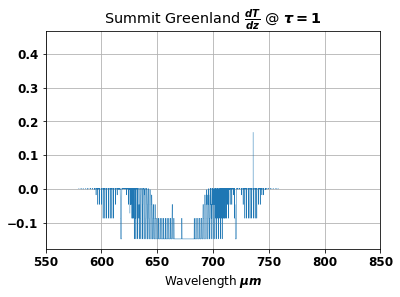

In [191]:
# plt.figure(figsize = (8,8))

plt.title(r'Summit Greenland $\frac{dT}{dz}$ @ $\tau = 1$')
plt.xlabel(r'Wavelength $\mu m$')
plt.plot(nu_, dT_dz, linewidth = 0.5)
# plt.xlim((12,18))
plt.xlim([550, 850])
plt.grid()
plt.savefig(save_figs_rel_dir + 'emission_height_plots/summit_greenland_dT_dz_7_1_22_30.png', dpi = 300)


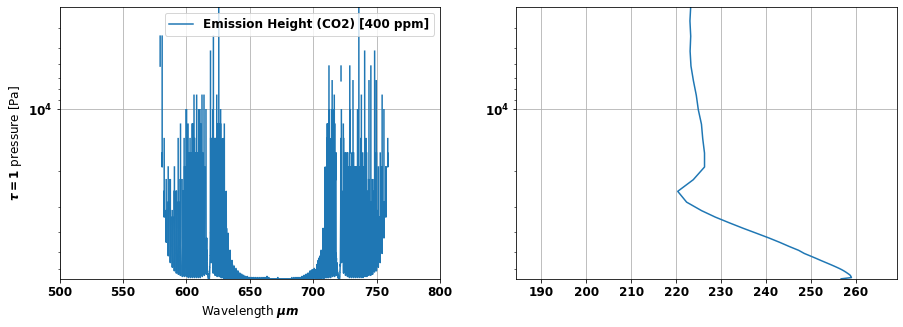

In [192]:
wl_nm = wl_nu*1e6
plot_emission_height(nu_, tau_wl, T_prof, p_prof,
                     label = 'Emission Height (CO2) [400 ppm]',
                     xlim = [500,800], ylim = [p_prof.max(), 10**3.5])
#                     xlim = [wl_nm.min(), wl_nm.max()]
#                     ave_emmission_pres = np.nanmean(tau_wl_co2_400))
# plt.xlim((12,18))
# plt.savefig(save_figs_rel_dir + 'emission_height_plots/summit_greenland_emission_height_v_k_7_1_22_30.png', dpi = 300)

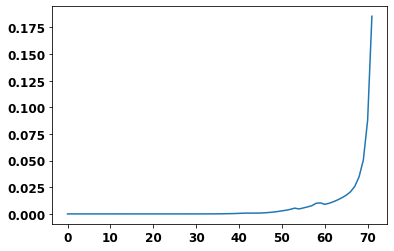

In [77]:
plt.plot(np.mean(Rdown, axis = 0))

In [58]:
3e4

30000.0

In [199]:
# Surface_Down,tau_wl_co2_400

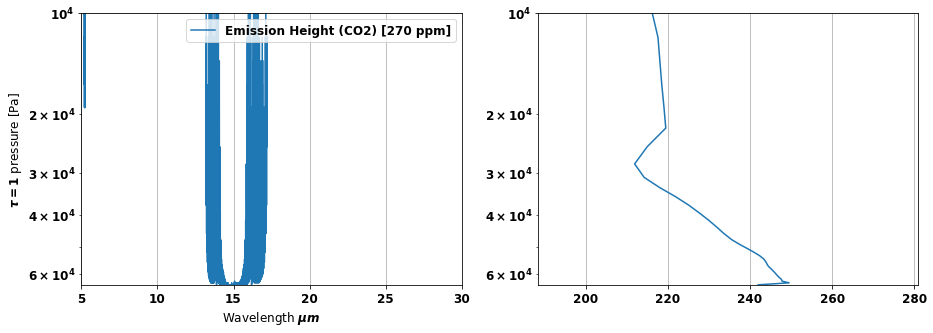

In [57]:
plot_emission_height(wl_nm, tau_wl, T_prof, p_prof, 
                     ylim = [p_prof.max(), 10**4],
                     label = 'Emission Height (CO2) [270 ppm]')

NameError: name 'tau_wl_co2_400' is not defined

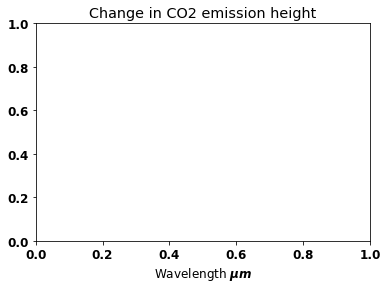

In [52]:
plt.title('Change in CO2 emission height')
plt.xlabel(r'Wavelength $\mu m$')
plt.plot(wl_nu*1e6, tau_wl_co2_400 - tau_wl_co2_270, linewidth = 0.5)
plt.xlim((12.5,17.6))
plt.ylim([0, 15000])
plt.grid()

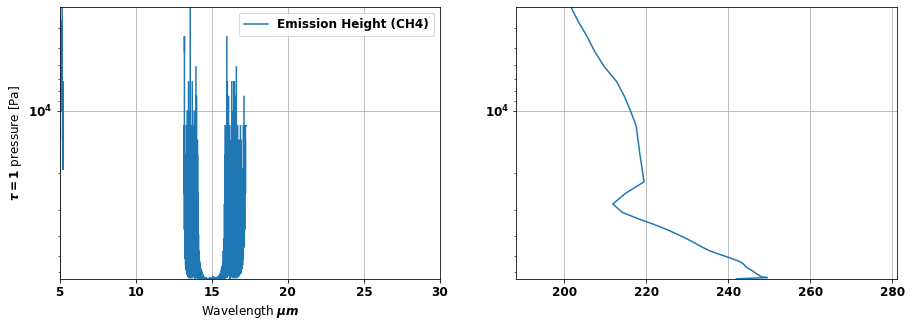

In [54]:
plot_emission_height(wl_nm, tau_wl, T_prof, p_prof,
                     ylim = [p_prof.max(), 10**3.5],
                     label = 'Emission Height (CH4)')

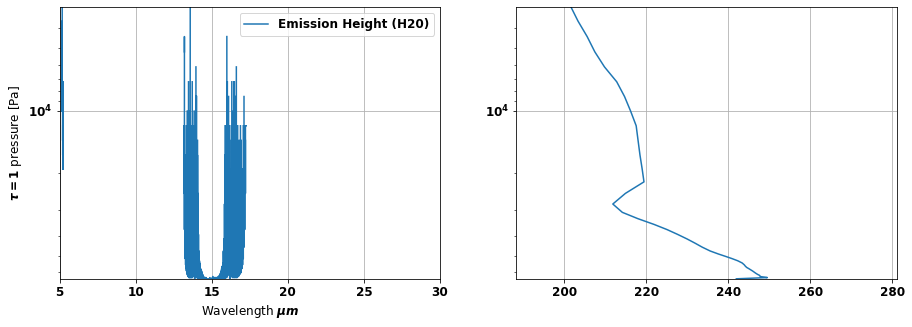

In [56]:
plot_emission_height(wl_nm, tau_wl, T_prof, p_prof,
                     ylim = [p_prof.max(), 10**3.5],
                     label = 'Emission Height (H20)')